# Import Libraries & Read Data

In [3]:
import gc
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow    # parquet engine library
from scipy.stats import loguniform

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier, early_stopping
import lightgbm as lgb

#from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


sns.set_palette("Set2")

%pylab inline
%matplotlib inline

pd.set_option('expand_frame_repr', False)  
pd.set_option('display.max_rows', None) 

Populating the interactive namespace from numpy and matplotlib


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
processed_train_path = '/content/drive/MyDrive/Amex_Default_Prediction_Kaggle_Competition/quickstart_train.csv'
train = pd.read_csv(processed_train_path)
train.rename(columns = {'Unnamed: 0': 'customer_ID'}, inplace = True)

In [6]:
train.head(3)

,customer_ID,B_1_last,B_2_last,B_3_last,B_4_last,B_5_last,B_6_last,B_7_last,B_8_last,B_9_last,...,S_11_avg,S_12_avg,S_13_avg,S_15_avg,S_16_avg,S_18_avg,S_22_avg,S_23_avg,S_25_avg,S_26_avg
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.009382,1.007647,0.007174,5,0.231717,0.149564,0.058425,0.0,0.009535,...,16.615385,0.247988,672.153846,4.692308,0.004974,0.0,0.916144,0.135036,0.974669,0.012560
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.034684,1.004028,0.005068,1,0.027000,0.167634,0.028411,0.0,0.012926,...,14.230769,0.181548,145.000000,5.615385,0.004212,0.0,0.908578,0.135614,0.975606,0.004071
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.004284,0.812650,0.007196,2,0.001557,0.183628,0.026981,0.0,0.009392,...,12.000000,0.190945,0.000000,8.000000,0.004086,0.0,0.300376,0.134748,0.973897,0.005923


In [7]:
'target' in train.columns

False

In [8]:
'customer_ID' in train.columns

True

In [9]:
target = pd.read_csv( '/content/drive/MyDrive/Amex_Default_Prediction_Kaggle_Competition/train_labels.csv').target.values 

In [10]:
processed_test_path = '/content/drive/MyDrive/Amex_Default_Prediction_Kaggle_Competition/quickstart_test.csv'
test = pd.read_csv(processed_test_path)
test.rename(columns = {'Unnamed: 0': 'customer_ID'}, inplace = True)

In [11]:
test.head(3)

,customer_ID,B_1_last,B_2_last,B_3_last,B_4_last,B_5_last,B_6_last,B_7_last,B_8_last,B_9_last,...,S_11_avg,S_12_avg,S_13_avg,S_15_avg,S_16_avg,S_18_avg,S_22_avg,S_23_avg,S_25_avg,S_26_avg
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.010779,1.009347,0.003576,9,0.050187,0.024945,0.163441,1.008730,0.005263,...,45.111111,0.136646,617.222222,7.555556,0.005912,0.0,0.962658,0.136015,0.973917,0.038056
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.016562,1.009245,0.011386,1,0.135907,0.182720,0.014466,1.008640,0.017454,...,9.230769,0.214804,356.923077,4.000000,0.005592,0.0,0.928724,0.135646,0.973939,0.006963
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.001484,0.810072,0.015938,32,0.004851,0.058534,0.090228,1.009375,0.008629,...,25.846154,0.163214,192.384615,6.153846,0.004803,0.0,0.683968,0.137155,0.973273,0.006683


In [12]:
print('train shape', train.shape)
print('test shape', test.shape)
print('target shape', target.shape)

train shape (458913, 470)
test shape (924621, 470)
target shape (458913,)


In [13]:
target

array([0, 0, 0, ..., 0, 1, 0])

In [14]:
train['target'] = target.tolist()

In [15]:
print('train shape', train.shape)

train shape (458913, 471)


In [16]:
cat_features =  ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120',  'D_126', 'D_63', 'D_64', 'D_66', 'D_68'] 
cat_features_avg = [f'{cf}_avg' for cf in cat_features]
cat_features_min = [f'{cf}_min' for cf in cat_features]
cat_features_max = [f'{cf}_max' for cf in cat_features]
cat_features_last = [f'{cf}_last' for cf in cat_features]
cat_features_0 = cat_features_avg + cat_features_min + cat_features_max + cat_features_last
cat_features = [col for col in train.columns if col in cat_features_0 ]
cat_features

['B_30_last',
 'B_38_last',
 'D_63_last',
 'D_64_last',
 'D_114_last',
 'D_120_last',
 'D_126_last',
 'B_30_max',
 'B_38_max',
 'D_63_max',
 'D_64_max',
 'D_116_max',
 'D_117_max',
 'D_126_max',
 'B_30_avg',
 'B_38_avg',
 'D_66_avg',
 'D_114_avg',
 'D_117_avg',
 'D_120_avg',
 'D_126_avg']

In [17]:
for cat_col in cat_features:
  encoder =  LabelEncoder()
  train[cat_col] = encoder.fit_transform(train[cat_col])
  test[cat_col] = encoder.fit_transform(test[cat_col])

In [18]:
'target' in train.columns

True

# Amex Score Matrix

In [19]:
# From https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
def amex_metric(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(y_true, y_pred),
            True)

# Show Summary Report Function

In [20]:
def show_summary_report(actual, prediction, probabilities):
    
    if isinstance(actual, pd.Series):
        actual = actual.values.astype(int)
    prediction = prediction.astype(int)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_score(actual, prediction))
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_score(actual, prediction))
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_score(actual, prediction))
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_score(actual, probabilities[:, 1]))
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction)
    average_precision = average_precision_score(actual, prediction)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, probabilities[:, 1])
    roc_auc = auc(fpr, tpr)


    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()

# Preprocessing

In [21]:
features = [c for c in train.columns if c not in [ 'customer_ID', 'target']]
X = train[features]
y = train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [22]:
X.head(3)

,B_1_last,B_2_last,B_3_last,B_4_last,B_5_last,B_6_last,B_7_last,B_8_last,B_9_last,B_10_last,...,S_11_avg,S_12_avg,S_13_avg,S_15_avg,S_16_avg,S_18_avg,S_22_avg,S_23_avg,S_25_avg,S_26_avg
0,0.009382,1.007647,0.007174,5,0.231717,0.149564,0.058425,0.0,0.009535,0.326101,...,16.615385,0.247988,672.153846,4.692308,0.004974,0.0,0.916144,0.135036,0.974669,0.012560
1,0.034684,1.004028,0.005068,1,0.027000,0.167634,0.028411,0.0,0.012926,0.297130,...,14.230769,0.181548,145.000000,5.615385,0.004212,0.0,0.908578,0.135614,0.975606,0.004071
2,0.004284,0.812650,0.007196,2,0.001557,0.183628,0.026981,0.0,0.009392,0.296313,...,12.000000,0.190945,0.000000,8.000000,0.004086,0.0,0.300376,0.134748,0.973897,0.005923


In [23]:
y[3]

0

# LGBM

In [24]:
# LGBM key structural parameters 
max_depth = [i for i in list(range(3,20,2))]       # more levels the tree has, makes the model more complex and prone to overfit, too low, will be underfit
num_leaves = [i for i in list(range(100, 500, 50))]            # decides tree structure, controls the num of decision leaves in a tree;can estimate as 2^(max_depth), but it impacts more than max depth, be cautious
min_data_in_leaf = [i for i in list(range(10,1000,50))] 

# LGBM key parameters for accuracy , these two features also used for early stopping and set low value for learning rate
n_estimators =  [i for i in list(range(10,400,20))]                                       # controls the number of decision trees,5000
learning_rate = [i/100 for i in list(range(1,32, 2))]             # step size paratmeter of the gradient descent, ease the overfitting

# LGBM other features to control overfitting
lambda_l1 = [i for i in list(range(0, 100, 10))]    # l2 and l2 is similar with reg_lambda and reg_alpha on XGBoost, these two are not directly correlated with overfitting
lambda_l2 = [i for i in list(range(0, 100, 10))] 
bagging_fraction = [i/10 for i in list(range(1,10, 1))]    # range within (0,1) should be smaller than 1.0; trial.suggest_float('bragging_fraction", 0.2, 0.95, step = 0.1)
bagging_freq = [1]   # integer value
feature_fraction = [i/10 for i in list(range(1,10, 1))]   # range within (0,1);trial.suggest_float('bragging_fraction", 0.2, 0.95, step = 0.1)

# Other
boosting =  ['gbdt']  # gbdt is default
#https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

In [25]:
random_grid_lgbm_params = {'num_leaves': num_leaves,
                            'max_depth': max_depth,
                            'num_leaves': num_leaves,
                            'min_data_in_leaf': min_data_in_leaf ,
                            'n_estimators': n_estimators,
                            'learning_rate': learning_rate,
                            'lambda_l1': lambda_l1,
                            'lambda_l2': lambda_l2,
                            'bagging_fraction': bagging_fraction,
                            'bagging_freq': bagging_freq,
                            'feature_fraction': feature_fraction ,
                           'boosting': boosting                      
               }

In [26]:
lgbm_model = lgb.LGBMClassifier()
lgbm_rgrid_model = RandomizedSearchCV(estimator = lgbm_model, param_distributions = random_grid_lgbm_params, cv = 6, n_iter = 10, verbose = True)

In [ ]:
lgbm_rgrid_model.fit(X_train, y_train)

Fitting 6 folds for each of 10 candidates, totalling 60 fits


RandomizedSearchCV(cv=6, estimator=LGBMClassifier(),
                   param_distributions={'bagging_fraction': [0.1, 0.2, 0.3, 0.4,
                                                             0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'bagging_freq': [1],
                                        'boosting': ['gbdt'],
                                        'feature_fraction': [0.1, 0.2, 0.3, 0.4,
                                                             0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'lambda_l1': [0, 10, 20, 30, 40, 50, 60,
                                                      70, 80, 90],
                                        'lambda_l2': [0, 10, 20, 30, 40, 50, 60,
                                                      70, 80, 90],
                                        'learning_rate': [0.01, 0.03, 

In [ ]:
lgbm_fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'amex_metric', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [ ]:
lgbm_rgrid_model.fit(X_train, y_train, **lgbm_fit_params)
print('Best score reached: {} with params: {} '.format(lgbm_rgrid_model.best_score_, lgbm_rgrid_model.best_params_))

Fitting 6 folds for each of 10 candidates, totalling 60 fits
Training until validation scores don't improve for 30 rounds.
[100]	valid's binary_logloss: 0.234444
[200]	valid's binary_logloss: 0.22524
Did not meet early stopping. Best iteration is:
[270]	valid's binary_logloss: 0.223035
Training until validation scores don't improve for 30 rounds.
[100]	valid's binary_logloss: 0.234378
[200]	valid's binary_logloss: 0.225163
Did not meet early stopping. Best iteration is:
[270]	valid's binary_logloss: 0.22302
Training until validation scores don't improve for 30 rounds.
[100]	valid's binary_logloss: 0.234224
[200]	valid's binary_logloss: 0.224943
Did not meet early stopping. Best iteration is:
[270]	valid's binary_logloss: 0.222879
Training until validation scores don't improve for 30 rounds.
[100]	valid's binary_logloss: 0.234417
[200]	valid's binary_logloss: 0.225159
Did not meet early stopping. Best iteration is:
[270]	valid's binary_logloss: 0.222974
Training until validation scores 

In [ ]:
best_random_lgbm_params =  lgbm_rgrid_model.best_params_
best_lgbm_model = lgb.LGBMClassifier()
best_lgbm_model.set_params(**best_random_lgbm_params)

LGBMClassifier(bagging_fraction=0.6, bagging_freq=1, boosting='gbdt',
               feature_fraction=0.5, lambda_l1=20, lambda_l2=70,
               learning_rate=0.05, max_depth=7, min_data_in_leaf=360,
               n_estimators=270, num_leaves=100)

In [ ]:
best_lgbm_model.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=0.6, bagging_freq=1, boosting='gbdt',
               feature_fraction=0.5, lambda_l1=20, lambda_l2=70,
               learning_rate=0.05, max_depth=7, min_data_in_leaf=360,
               n_estimators=270, num_leaves=100)

Accuracy : 0.9092 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8248 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8257 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9651                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


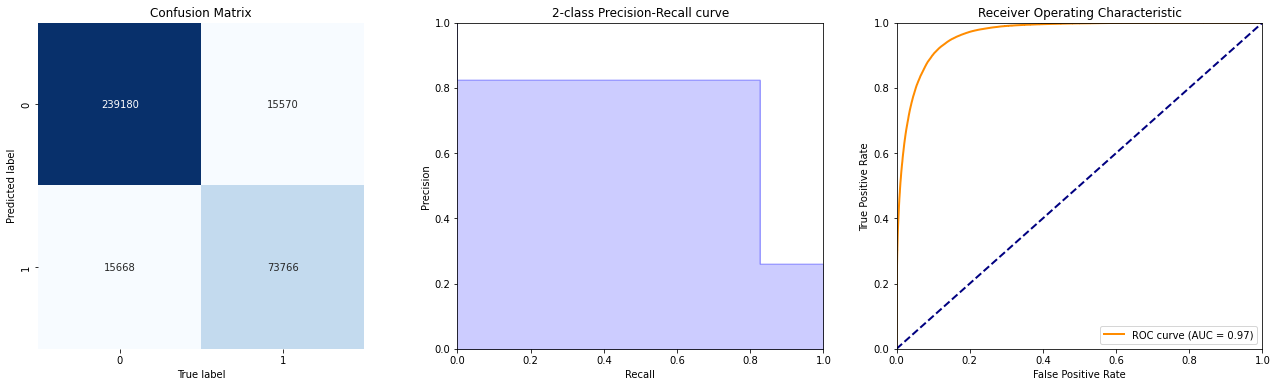

In [ ]:
y_train_pred = best_lgbm_model.predict(X_train)
y_train_prob = best_lgbm_model.predict_proba(X_train)
show_summary_report(y_train, y_train_pred, y_train_prob)

Accuracy : 0.9013 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8080 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8080 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9595                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


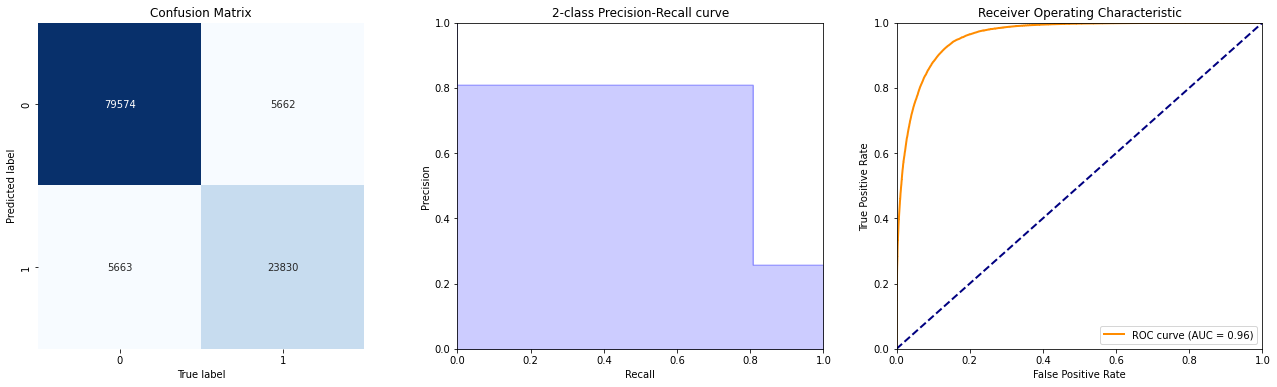

In [ ]:
y_test_pred = best_lgbm_model.predict(X_test)
y_test_prob = best_lgbm_model.predict_proba(X_test)
show_summary_report(y_test, y_test_pred, y_test_prob)

# Submission

In [ ]:
sub_features = [c for c in train.columns if c not in ['customer_ID',  'target']]
submission_test = test[sub_features ]
submission_test.head(3)

,B_1_last,B_2_last,B_3_last,B_4_last,B_5_last,B_6_last,B_7_last,B_8_last,B_9_last,B_10_last,...,S_11_avg,S_12_avg,S_13_avg,S_15_avg,S_16_avg,S_18_avg,S_22_avg,S_23_avg,S_25_avg,S_26_avg
0,0.010779,1.009347,0.003576,9,0.050187,0.024945,0.163441,1.008730,0.005263,0.033599,...,45.111111,0.136646,617.222222,7.555556,0.005912,0.0,0.962658,0.136015,0.973917,0.038056
1,0.016562,1.009245,0.011386,1,0.135907,0.182720,0.014466,1.008640,0.017454,0.298735,...,9.230769,0.214804,356.923077,4.000000,0.005592,0.0,0.928724,0.135646,0.973939,0.006963
2,0.001484,0.810072,0.015938,32,0.004851,0.058534,0.090228,1.009375,0.008629,0.129189,...,25.846154,0.163214,192.384615,6.153846,0.004803,0.0,0.683968,0.137155,0.973273,0.006683


In [ ]:
y_pred_submission = best_lgbm_model.predict(submission_test )
y_pred_submission.shape

(924621,)

In [ ]:
y_pred_submission[:10]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0])

In [ ]:
test = test.reset_index()

In [ ]:
data_submission =  pd.DataFrame({'customer_ID': test.customer_ID, 'prediction':y_pred_submission })
data_submission.set_index('customer_ID', inplace = True)
data_submission.head(3)

,prediction
customer_ID,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,0
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,0
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,0


In [ ]:
path = '/content/drive/MyDrive/Amex_Default_Prediction_Kaggle_Competition'

In [ ]:
data_submission.to_csv(path+ '/submission_120822_quickstart_best_params2_cv6.csv')